In [4]:
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    auc,
    classification_report
)
from sklearn.ensemble import IsolationForest, RandomForestClassifier

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [5]:
# Load ML-EdgeIIoT-dataset (Selected dataset for ML)
df = pd.read_csv("ML-EdgeIIoT-dataset.csv", low_memory=False)
print("Original shape:", df.shape)

# Check attack-related columns
attack_cols = [c for c in df.columns if "Attack" in c or "attack" in c.lower()]
print("Attack-related columns:", attack_cols)

print(df[attack_cols].head())
print(df["Attack_type"].value_counts().head(15))


Original shape: (157800, 63)
Attack-related columns: ['Attack_label', 'Attack_type']
   Attack_label Attack_type
0             1        MITM
1             1        MITM
2             1        MITM
3             1        MITM
4             1        MITM
Attack_type
Normal                   24301
DDoS_UDP                 14498
DDoS_ICMP                14090
Ransomware               10925
DDoS_HTTP                10561
SQL_injection            10311
Uploading                10269
DDoS_TCP                 10247
Backdoor                 10195
Vulnerability_scanner    10076
Port_Scanning            10071
XSS                      10052
Password                  9989
MITM                      1214
Fingerprinting            1001
Name: count, dtype: int64


In [ ]:
# Keep rows where Attack_type is present
df = df[df["Attack_type"].notna()].copy()

df["Attack_type"] = df["Attack_type"].astype(str).str.strip()

df["Attack_label"] = np.where(df["Attack_type"] == "Normal", 0, 1)

print("Binary label distribution:\n", df["Attack_label"].value_counts())


Binary label distribution:
 Attack_label
1    133499
0     24301
Name: count, dtype: int64


In [7]:
drop_columns = [
    "frame.time", "ip.src_host", "ip.dst_host",
    "arp.src.proto_ipv4", "arp.dst.proto_ipv4",
    "http.file_data", "http.request.full_uri",
    "icmp.transmit_timestamp",
    "http.request.uri.query",
    "tcp.options", "tcp.payload",
    "tcp.srcport", "tcp.dstport",
    "udp.port", "mqtt.msg"
]

df = df.drop(columns=[c for c in drop_columns if c in df.columns],
             errors="ignore")

print("After dropping some columns:", df.shape)


After dropping some columns: (157800, 48)


In [8]:
feature_cols = [c for c in df.columns if c not in ["Attack_label"]]

# Convert all non-numeric feature values to NaN, then fill with 0
df[feature_cols] = df[feature_cols].apply(
    lambda col: pd.to_numeric(col, errors="coerce")
)

df[feature_cols] = df[feature_cols].fillna(0)

print("Any NaNs left in features?", df[feature_cols].isna().sum().sum())
print("Final df shape:", df.shape)


Any NaNs left in features? 0
Final df shape: (157800, 48)


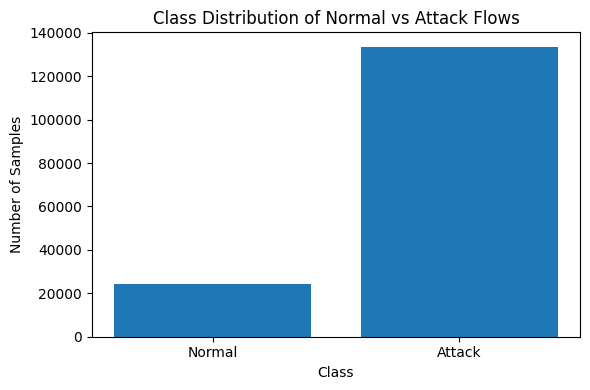

In [22]:
import matplotlib.pyplot as plt

counts = y_full.value_counts().sort_index()

plt.figure(figsize=(6,4))
plt.bar(["Normal", "Attack"], [counts[0], counts[1]])
plt.title("Class Distribution of Normal vs Attack Flows")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.tight_layout()
plt.savefig("fig_class_distribution.png", dpi=300)
plt.show()


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df[feature_cols]
y = df["Attack_label"]

print("Label distribution:\n", y.value_counts())

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Label distribution:
 Attack_label
1    133499
0     24301
Name: count, dtype: int64
Train shape: (126240, 47)
Test shape: (31560, 47)


In [1]:
results_summary = []

def evaluate_and_store(y_true, y_pred, model_name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    print(f"\n===== {model_name} =====")
    print("Accuracy :", acc)
    print("Precision:", prec)
    print("Recall   :", rec)
    print("F1-score :", f1)
    print("\nClassification report:")
    print(classification_report(y_true, y_pred, zero_division=0))
    print("Confusion matrix:")
    print(confusion_matrix(y_true, y_pred))
    
    results_summary.append({
        "Model": model_name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-score": f1
    })


In [12]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]  # probability of class 1 (Attack)

evaluate_and_store(y_test, y_pred_rf, "Random Forest")



===== Random Forest =====
Accuracy : 0.9686628643852978
Precision: 0.975196835840757
Recall   : 0.9880898876404495
F1-score : 0.9816010269194277

Classification report:
              precision    recall  f1-score   support

           0       0.93      0.86      0.89      4860
           1       0.98      0.99      0.98     26700

    accuracy                           0.97     31560
   macro avg       0.95      0.93      0.94     31560
weighted avg       0.97      0.97      0.97     31560

Confusion matrix:
[[ 4189   671]
 [  318 26382]]


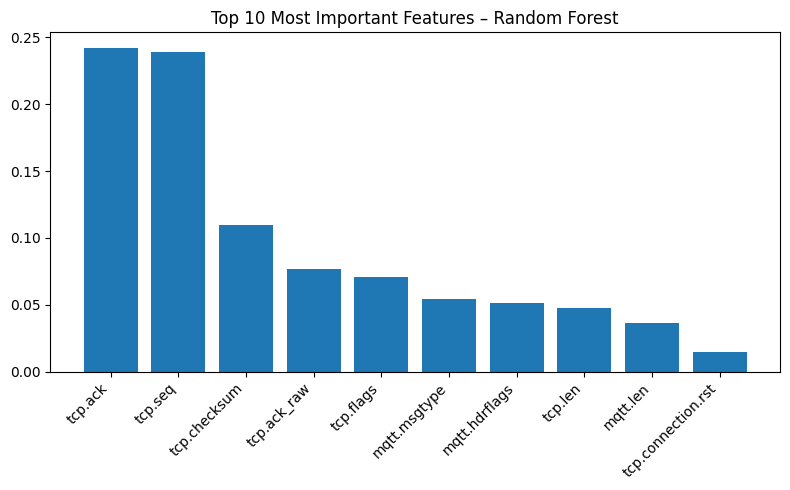

In [13]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1][:10]  # top 10

plt.figure(figsize=(8, 5))
plt.bar(range(len(indices)), importances[indices])
plt.xticks(range(len(indices)), [feature_cols[i] for i in indices], rotation=45, ha="right")
plt.title("Top 10 Most Important Features – Random Forest")
plt.tight_layout()
plt.savefig("fig_rf_feature_importance.png", dpi=300)
plt.show()


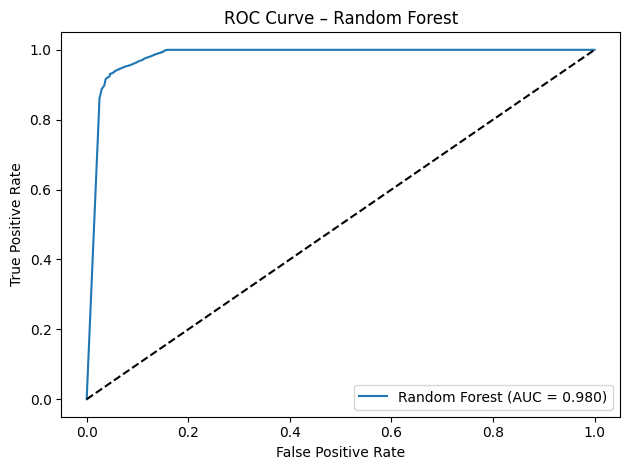

In [14]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba_rf)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"Random Forest (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Random Forest")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("fig_rf_roc_curve.png", dpi=300)
plt.show()


In [15]:
iso = IsolationForest(
    n_estimators=100,
    contamination="auto",
    random_state=42,
    n_jobs=-1
)

X_train_scaled_benign = X_train_scaled[y_train == 0]
iso.fit(X_train_scaled_benign)

y_pred_if = iso.predict(X_test_scaled)

# 1 = normal, -1 = anomaly → convert to 0/1: 0=Normal,1=Attack
y_pred_if_bin = np.where(y_pred_if == 1, 0, 1)

evaluate_and_store(y_test, y_pred_if_bin, "Isolation Forest")



===== Isolation Forest =====
Accuracy : 0.32449302915082384
Precision: 0.8596444325624917
Recall   : 0.24086142322097379
F1-score : 0.3762909218571721

Classification report:
              precision    recall  f1-score   support

           0       0.16      0.78      0.26      4860
           1       0.86      0.24      0.38     26700

    accuracy                           0.32     31560
   macro avg       0.51      0.51      0.32     31560
weighted avg       0.75      0.32      0.36     31560

Confusion matrix:
[[ 3810  1050]
 [20269  6431]]


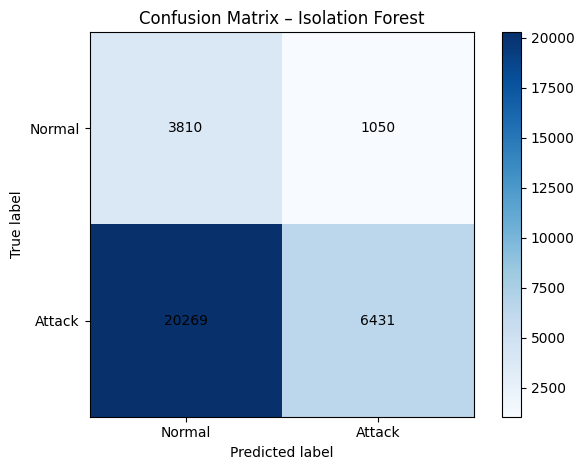

Saved: fig_cm_isolation_forest.png
Isolation Forest CM (rows=true, cols=pred):
 [[ 3810  1050]
 [20269  6431]]


In [16]:
cm_if = confusion_matrix(y_test, y_pred_if_bin)

fig, ax = plt.subplots()
im = ax.imshow(cm_if, cmap="Blues")

ax.set_xticks(np.arange(2))
ax.set_yticks(np.arange(2))
ax.set_xticklabels(["Normal", "Attack"])
ax.set_yticklabels(["Normal", "Attack"])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix – Isolation Forest")

for i in range(2):
    for j in range(2):
        ax.text(j, i, cm_if[i, j], ha="center", va="center", color="black")

plt.colorbar(im)
plt.tight_layout()
plt.savefig("fig_cm_isolation_forest.png", dpi=300)
plt.show()

print("Saved: fig_cm_isolation_forest.png")
print("Isolation Forest CM (rows=true, cols=pred):\n", cm_if)


In [17]:
# Train autoencoder only on normal traffic
X_train_ae = X_train_scaled[y_train == 0]
input_dim = X_train_ae.shape[1]

autoencoder = keras.Sequential([
    layers.Dense(32, activation="relu", input_shape=(input_dim,)),
    layers.Dense(16, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(input_dim, activation="linear")
])

autoencoder.compile(optimizer="adam", loss="mse")

history = autoencoder.fit(
    X_train_ae, X_train_ae,
    epochs=20,
    batch_size=256,
    validation_split=0.1,
    verbose=0
)

# Reconstruction error
X_test_pred = autoencoder.predict(X_test_scaled, verbose=0)
mse = np.mean(np.power(X_test_scaled - X_test_pred, 2), axis=1)

# Threshold from benign samples in test set
benign_mask = (y_test == 0).values
threshold = np.percentile(mse[benign_mask], 95)

y_pred_ae = (mse > threshold).astype(int)

evaluate_and_store(y_test, y_pred_ae, "Autoencoder")


C:\Users\sujan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



===== Autoencoder =====
Accuracy : 0.5512674271229404
Precision: 0.9813421375921376
Recall   : 0.478689138576779
F1-score : 0.6434900815627832

Classification report:
              precision    recall  f1-score   support

           0       0.25      0.95      0.39      4860
           1       0.98      0.48      0.64     26700

    accuracy                           0.55     31560
   macro avg       0.62      0.71      0.52     31560
weighted avg       0.87      0.55      0.61     31560

Confusion matrix:
[[ 4617   243]
 [13919 12781]]


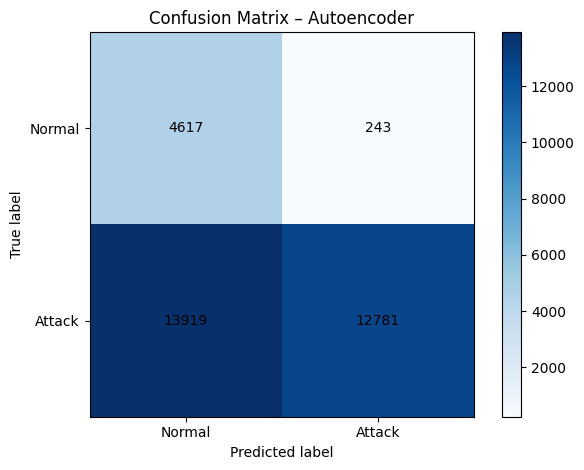

In [23]:
cm_ae = confusion_matrix(y_test, y_pred_ae)

fig, ax = plt.subplots()
im = ax.imshow(cm_ae, cmap="Blues")

ax.set_xticks(np.arange(2))
ax.set_yticks(np.arange(2))
ax.set_xticklabels(["Normal", "Attack"])
ax.set_yticklabels(["Normal", "Attack"])

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix – Autoencoder")

for i in range(2):
    for j in range(2):
        ax.text(j, i, cm_ae[i, j],
                ha="center", va="center", color="black")

plt.colorbar(im)
plt.tight_layout()
plt.savefig("fig_cm_autoencoder.png", dpi=300)
plt.show()

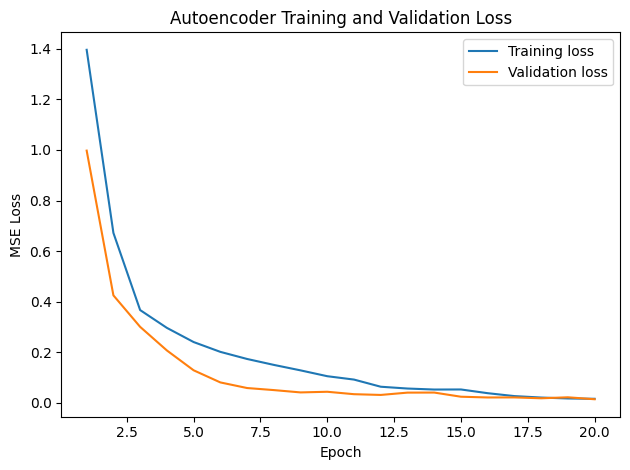

In [18]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, label="Training loss")
plt.plot(epochs, val_loss, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Autoencoder Training and Validation Loss")
plt.legend()
plt.tight_layout()
plt.savefig("fig_autoencoder_loss.png", dpi=300)
plt.show()


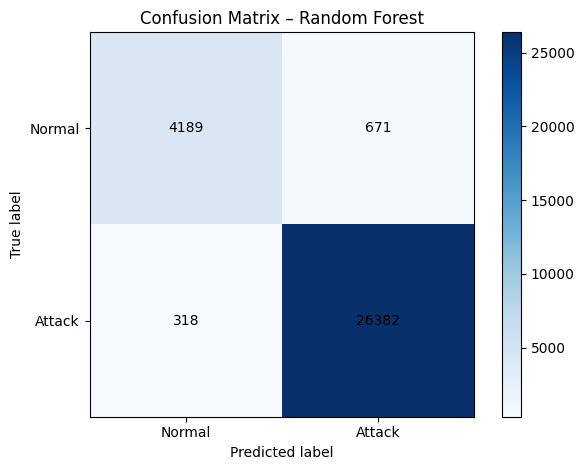

In [19]:
cm = confusion_matrix(y_test, y_pred_rf)
fig, ax = plt.subplots()
im = ax.imshow(cm, cmap="Blues")

ax.set_xticks(np.arange(2))
ax.set_yticks(np.arange(2))
ax.set_xticklabels(["Normal", "Attack"])
ax.set_yticklabels(["Normal", "Attack"])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix – Random Forest")

for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha="center", va="center", color="black")

plt.colorbar(im)
plt.tight_layout()
plt.savefig("fig_cm_random_forest.png", dpi=300)
plt.show()


In [20]:
results_df = pd.DataFrame(results_summary)
print(results_df)

results_df.to_csv("model_results_summary.csv", index=False)


              Model  Accuracy  Precision    Recall  F1-score
0     Random Forest  0.968663   0.975197  0.988090  0.981601
1  Isolation Forest  0.324493   0.859644  0.240861  0.376291
2       Autoencoder  0.551267   0.981342  0.478689  0.643490


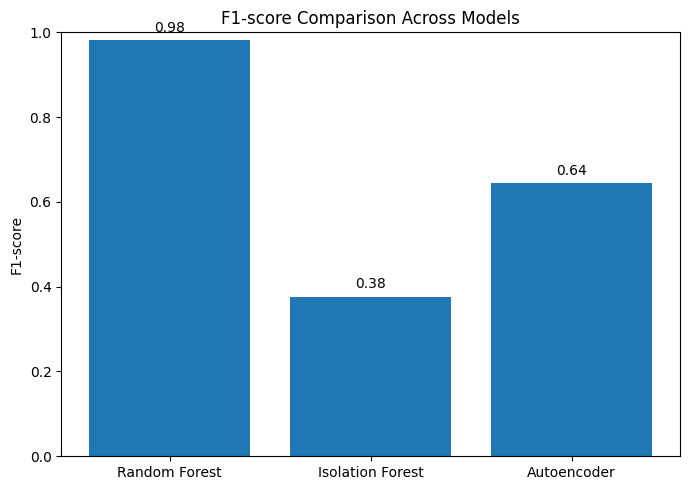

In [21]:
import matplotlib.pyplot as plt

# Model names and F1-scores (from your final results)
models = ["Random Forest", "Isolation Forest", "Autoencoder"]
f1_scores = [0.9816, 0.3763, 0.6435]

plt.figure(figsize=(7, 5))
plt.bar(models, f1_scores)
plt.ylabel("F1-score")
plt.ylim(0, 1.0)
plt.title("F1-score Comparison Across Models")

for i, score in enumerate(f1_scores):
    plt.text(i, score + 0.02, f"{score:.2f}", ha="center")

plt.tight_layout()
plt.savefig("fig_f1_score_comparison.png", dpi=300)
plt.show()
